In [21]:
job_list = ['стоматолог', 
            'медсестра', 
            'сиделка', 
            'фармацевт']
max_samples = 400
area = 'Москва'
if area:
    area_id = area_parse(area)

In [19]:
import pandas as pd
import numpy as np
import pymorphy2
import matplotlib.pyplot as plt
import requests
import json
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
def area_tree_lookup(tree, query):
    for area in tree:
        if query in (area['name'].lower()):
            return area['id']
        elif area['areas']:
            if area_tree_lookup(area['areas'], query):
                return area_tree_lookup(area['areas'], query)

In [20]:
def area_parse(area_name):
    area_name = area_name.lower()
    area_tree = get("https://api.hh.ru/areas")
    area_id = area_tree_lookup(area_tree, area_name)
    if not area_id:
        print('Неправильно введен город/регион.')
    else:
        return int(area_id)

In [22]:
def get(query, timeout=5, max_retries=5, backoff_factor=0.3):
    """ Выполнить GET-запрос

    :param query: запрос с адресом
    :param timeout: максимальное время ожидания ответа от сервера
    :param max_retries: максимальное число повторных запросов
    :param backoff_factor: коэффициент экспоненциального нарастания задержки
    """
    import time
    import random
    delay = 0
    for i in range(max_retries):
        try:
            response = requests.get(query)
            return response.json()
        except:
            pass
        time.sleep(delay)
        delay = min(delay * backoff_factor, timeout)
        delay += random.random()
    return response

In [23]:
def get_id_page_counts(job_name, area):
    print(job_name)
    query_data = {
        "job_name": job_name,
        "area": area
    }
    query = "https://api.hh.ru/vacancies?text={job_name}&area={area}".format(**query_data)
    result = get(query)
    # print(result)
    return (result['found'], result['pages'])

In [24]:
def get_vacancy_ids(job_name, area):
    query_data = {
        "job_name": job_name,
        "page": 0,
        "area": area
    }
    id_count, page_count = get_id_page_counts(job_name, area)
    id_list = []
    while query_data['page']<page_count:
        query = "https://api.hh.ru/vacancies?text={job_name}&page={page}&area={area}".format(**query_data)
        result = get(query)
        query_data["page"] += 1
        for i in range(len(result['items'])):
            id_list.append(result['items'][i]['id'])
    return id_list

In [25]:
def parse_append(raw_data, json_data):
    try:
        if not json_data:
            json_data={
                    'id': [],
                    'name': [],
                    'schedule': [],
                    'employment':[],
                    'experience':[],
                    'salary_min': [],
                    'salary_max': [],
                    'currency': [],
                    'description': []
        }
        json_data['id'].append(raw_data['id'])
        json_data['name'].append(raw_data['name'])
        json_data['schedule'].append(raw_data['schedule']['id'])
        json_data['employment'].append(raw_data['employment']['id'])
        json_data['experience'].append(raw_data['experience']['id'])
        if raw_data['salary']:
            if raw_data['salary']['from'] == None: 
                json_data['salary_min'].append(raw_data['salary']['to'])
            else:
                json_data['salary_min'].append(raw_data['salary']['from'])
            if raw_data['salary']['to'] == None: 
                json_data['salary_max'].append(raw_data['salary']['from'])
            else:
                json_data['salary_max'].append(raw_data['salary']['to'])
            json_data['currency'].append(raw_data['salary']['currency'])
        else:
            json_data['salary_min'].append(None)
            json_data['salary_max'].append(None)
            json_data['currency'].append(None)
        json_data['description'].append(raw_data['description'])
        return json_data
    except:
        print(raw_data)

In [26]:
def ids_to_data(id_list, area):
    job_json = {}
    for i in range(len(id_list)):
        query = "https://api.hh.ru/vacancies/" + id_list[i]
        job_json = parse_append(get(query), job_json)
    return job_json        

In [27]:
def get_job_data(job_name, count=None, area=113):
    id_list = get_vacancy_ids(job_name, area)
    if count:
        return ids_to_data(id_list[:count], area)
    return ids_to_data(id_list, area)

In [28]:
def normalize_currency(job_entry):
    if job_entry.currency == 'USD':
        job_entry.currency = 'RUR'
        job_entry.salary *= 75
    if job_entry.currency == 'EUR':
        job_entry.currency = 'RUR'
        job_entry.salary *= 90
    return job_entry

In [29]:
def normalize_salary(job_df):
    job_df.insert(loc=4, column='salary', value=((job_df['salary_min']+job_df['salary_max'])/2))
    job_df = job_df.apply(normalize_currency, axis=1)
    return job_df.drop(columns=['salary_min', 'salary_max', 'currency'])

In [30]:
def vectorize_description(desc_dict, stop_words):
    count_list = []
    for job in desc_dict.keys():
        text = desc_dict[job]
        morph = pymorphy2.MorphAnalyzer()
        normalized_text = ' '.join(morph.parse(word)[0].normal_form for word in text.split())
        count_vectorizer = CountVectorizer(stop_words=stop_words, ngram_range=(1,3))
        count_data = count_vectorizer.fit_transform([normalized_text])
        words = count_vectorizer.get_feature_names()
        total_counts = np.zeros(len(words))
        for t in count_data:
            total_counts+=t.toarray()[0]
        count_dict = (zip(words, total_counts))
        count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[:]
        words = [w[0] for w in count_dict]
        counts = [w[1] for w in count_dict]
        word_counts = pd.DataFrame(words, range(len(words)), columns=['words'])
        word_counts['counts'] = counts
        count_list.append((job, word_counts.head(20)))
    return count_list

In [31]:
def tfidf(desc_dict, stop_words):
    desc_list = [(desc_dict[job], job) for job in desc_dict.keys()]
    morph = pymorphy2.MorphAnalyzer()
    corpus = []
    name_list = []
    for desc in desc_list:
        line = desc[0].translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
        normalized_text = ' '.join(morph.parse(word)[0].normal_form for word in line.split())
        corpus.append(normalized_text)
        name_list.append(desc[1])
    tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df=0.5)
    tfidf_data = tfidf_vectorizer.fit_transform(corpus)
    return tfidf_vectorizer, tfidf_data, name_list

In [32]:
job_df_list = {}
for i in range(len(job_list)):
    job_df_list[job_list[i]] = {}

In [33]:
if area:
    for job in job_df_list.keys():
        job_df_list[job] = pd.DataFrame(get_job_data(job, count = max_samples, area = area_id))
else:
    for job in job_df_list.keys():
        job_df_list[job] = pd.DataFrame(get_job_data(job, count = max_samples))

стоматолог
медсестра
сиделка
фармацевт


In [34]:
for job in job_df_list.keys():
    if job == list(job_df_list.keys())[0]:
        job_df_full = job_df_list[job].head(max_samples)
        job_df_full.insert(loc=2, column='job_type', value=job)
    else:
        job_df_full = job_df_full.append(job_df_list[job])
        job_df_full['job_type'] = job_df_full['job_type'].fillna(job)

In [35]:
job_df_full.head()

,id,name,job_type,schedule,employment,experience,salary_min,salary_max,currency,description
0,44649591,Стоматолог-ортопед,стоматолог,fullDay,part,moreThan6,300000.0,1000000.0,RUR,<p>Центр дентальной ортопедии и имплантологии ...
1,44528351,Стоматолог-терапевт,стоматолог,fullDay,full,between3And6,90000.0,350000.0,RUR,<p>Требования:</p> <p>умения и знания современ...
2,44676025,Врач стоматолог-терапевт,стоматолог,shift,full,moreThan6,100000.0,160000.0,RUR,<p>Обязанности:</p> <ul> <li>Терапевтическое л...
3,44675436,Врач-стоматолог терапевт- эндодонт,стоматолог,fullDay,full,between3And6,100000.0,150000.0,EUR,<p> Требуется опытный‚ прогрессивный врач стом...
4,44165931,Старший администратор в стоматологию,стоматолог,fullDay,full,between3And6,100000.0,100000.0,RUR,<strong>Обязанности:</strong> <ul> <li>Входящи...


In [36]:
job_df_full = normalize_salary(job_df_full)
job_df_full.head()

,id,name,job_type,schedule,salary,employment,experience,description
0,44649591,Стоматолог-ортопед,стоматолог,fullDay,650000.0,part,moreThan6,<p>Центр дентальной ортопедии и имплантологии ...
1,44528351,Стоматолог-терапевт,стоматолог,fullDay,220000.0,full,between3And6,<p>Требования:</p> <p>умения и знания современ...
2,44676025,Врач стоматолог-терапевт,стоматолог,shift,130000.0,full,moreThan6,<p>Обязанности:</p> <ul> <li>Терапевтическое л...
3,44675436,Врач-стоматолог терапевт- эндодонт,стоматолог,fullDay,11250000.0,full,between3And6,<p> Требуется опытный‚ прогрессивный врач стом...
4,44165931,Старший администратор в стоматологию,стоматолог,fullDay,100000.0,full,between3And6,<strong>Обязанности:</strong> <ul> <li>Входящи...


In [37]:
with open('stop_words.txt', encoding = 'utf8') as file:
    stop_words = file.readlines()
stop_words = [i[:-1] for i in stop_words]
extra_words = [
    'li',
    'ul',
    'strong',
    'br',
    'of',
    'to',
    'and',
    'in',
    'for',
    'with',
    'the',
    'em',
    'требование',
    'свой',
    'работа',
    'компания',
    'команда',
    'возможность',
    'разработка',
    'разработчик',
    'работать',
    'решение',
    'требование',
    'новый',
    'условие',
    'знание',
    'проект',
    'продукт',
    'умение',
    'офис',
    'система',
    'опыт',
    'навык',
    'задача',
    'уровень',
    'quot',
]
stop_words += extra_words

In [38]:
desc_dict = job_df_full.groupby('job_type')['description'].apply(','.join).to_dict()
job_df_full = job_df_full.drop(columns=['description'])

In [39]:
count_list = vectorize_description(desc_dict, stop_words)

In [40]:
vec, data, job_names = tfidf(desc_dict, stop_words)

In [41]:
tfidf_dict = {}
for i in range(len(job_list)):
    df = pd.DataFrame(data[i].T.todense(), index=vec.get_feature_names(), columns=["TF-IDF"])
    df = df.sort_values('TF-IDF', ascending=False)
    tfidf_dict[job_names[i]] = df

In [42]:
def translate_employment(label):
    if label == 'full':
        return 'Полная занятость'
    elif label == 'part':
        return 'Частичная занятость'
    elif label == 'project':
        return 'Проектная работа'
    elif label == 'probation':
        return 'Стажировка'
    return label

In [43]:
def translate_schedule(label):
    if label == 'fullDay':
        return 'Полный день'
    elif label == 'flexible':
        return 'Гибкий график'
    elif label == 'shift':
        return 'Сменный график'
    elif label == 'remote':
        return 'Удаленная работа'
    elif label == 'flyInFlyOut':
        return 'Вахтовый метод'
    return label

In [44]:
def translate_experience(label):
    if label == 'noExperience':
        return 'Нет опыта'
    elif label == 'between1And3':
        return 'От 1 до 3 лет'
    elif label == 'between3And6':
        return 'От 3 до 6 лет'
    elif label == 'moreThan6':
        return 'Более 6 лет'
    return label

In [45]:
job_df_full['employment'] = job_df_full['employment'].apply(translate_employment)
job_df_full['schedule'] = job_df_full['schedule'].apply(translate_schedule)
job_df_full['experience'] = job_df_full['experience'].apply(translate_experience)

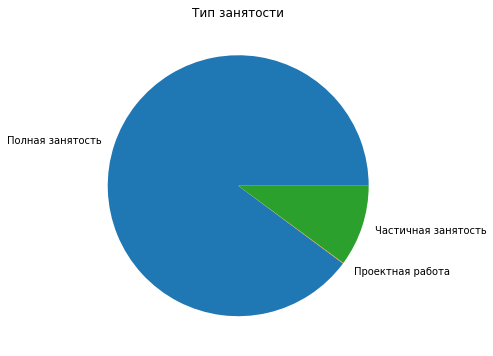

In [46]:
job_df_class = job_df_full.groupby('employment').size()
job_df_class.plot(kind='pie', figsize=(6, 6), label="")
plt.title("Тип занятости")
plt.show()

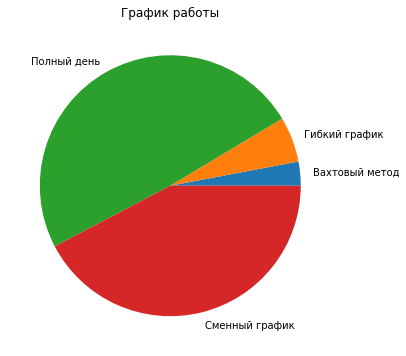

In [47]:
job_df_class = job_df_full.groupby('schedule').size()
job_df_class.plot(kind='pie', figsize=(6, 6), label="")
plt.title("График работы")
plt.show()

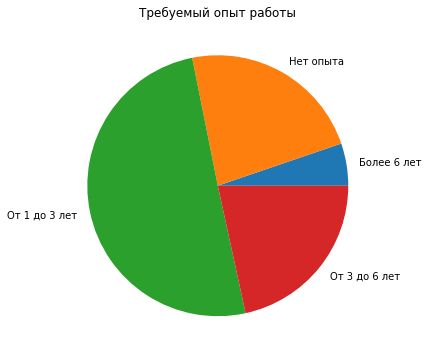

In [48]:
job_df_class = job_df_full.groupby('experience').size()
job_df_class.plot(kind='pie', figsize=(6, 6), label="")
plt.title("Требуемый опыт работы")
plt.show()

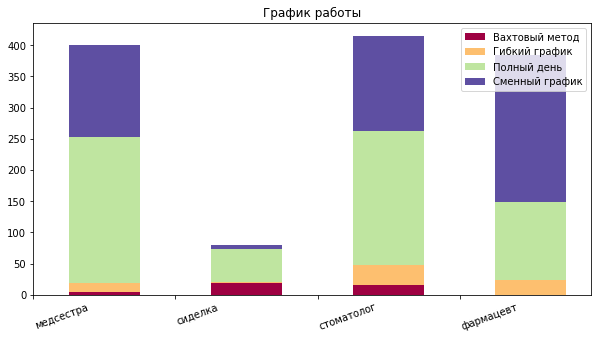

In [49]:
x_var = 'job_type'
groupby_var = 'schedule'
job_df_agg = job_df_full.loc[:, [x_var, groupby_var]].groupby(groupby_var)
vals = [job_df_full[x_var].astype('category').cat.codes.values.tolist() for i, job_df_full in job_df_agg]
plt.figure(figsize=(10,5))
colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
n, bins, patches = plt.hist(vals, job_df_full[x_var].unique().__len__(), color=colors[:len(vals)], rwidth=0.5, stacked=True, density=False)
plt.legend({group:col for group, col in zip(np.unique(job_df_full[groupby_var]).tolist(), colors[:len(vals)])})
plt.xticks(bins[:-1], np.unique(job_df_full[x_var]).tolist(), rotation=20, horizontalalignment='left')
plt.title("График работы")
plt.show()

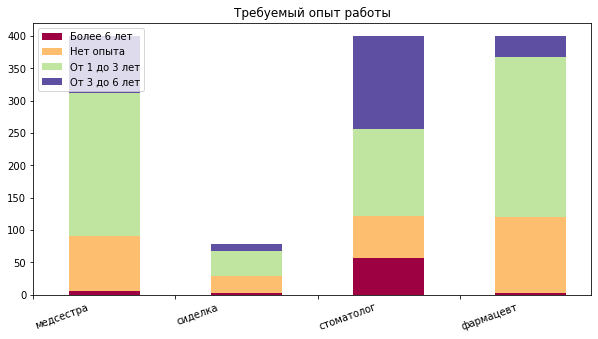

In [50]:
x_var = 'job_type'
groupby_var = 'experience'
job_df_agg = job_df_full.loc[:, [x_var, groupby_var]].groupby(groupby_var)
vals = [job_df_full[x_var].astype('category').cat.codes.values.tolist() for i, job_df_full in job_df_agg]
plt.figure(figsize=(10,5))
colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
n, bins, patches = plt.hist(vals, job_df_full[x_var].unique().__len__(), color=colors[:len(vals)], rwidth=0.5, stacked=True, density=False)
plt.legend({group:col for group, col in zip(np.unique(job_df_full[groupby_var]).tolist(), colors[:len(vals)])})
plt.xticks(bins[:-1], np.unique(job_df_full[x_var]).tolist(), rotation=20, horizontalalignment='left')
plt.title("Требуемый опыт работы")
plt.show()

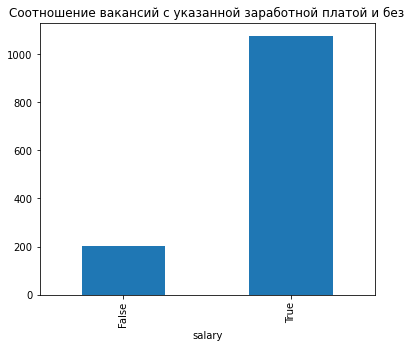

In [51]:
# Entries with/without salary
job_df_class = job_df_full.groupby(job_df_full['salary']>0).size()
job_df_class.plot(kind='bar',figsize=(6, 5))
plt.title("Соотношение вакансий с указанной заработной платой и без")
plt.show()

In [52]:
salary_df = job_df_full[job_df_full['salary']>0]

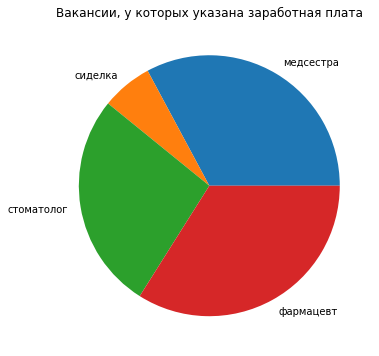

In [53]:
job_df_class = salary_df.groupby('job_type').size()
job_df_class.plot(kind='pie', figsize=(6, 6), label="")
plt.title("Вакансии, у которых указана заработная плата")
plt.show()

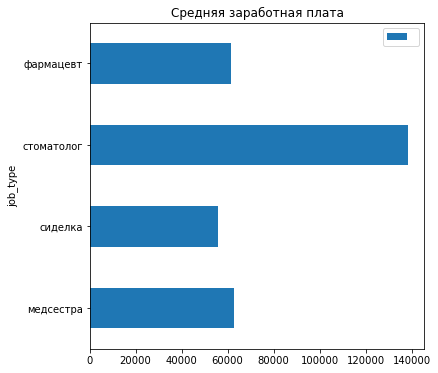

In [54]:
job_df_class = salary_df.groupby('job_type').sum()
job_df_class['salary'] /= salary_df.groupby('job_type').size()
job_df_class.plot(kind='barh', y='salary', figsize=(6, 6), label="")
plt.title("Средняя заработная плата")
plt.show()

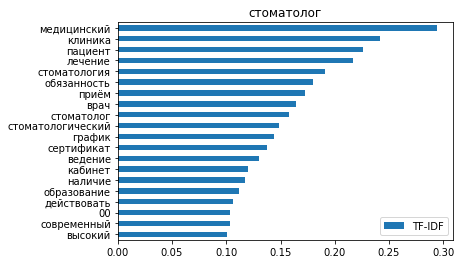

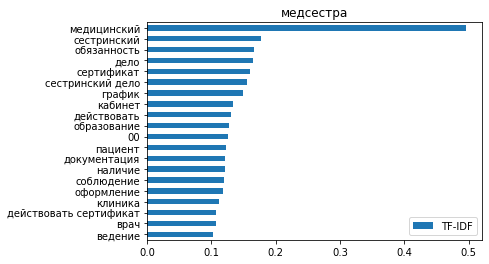

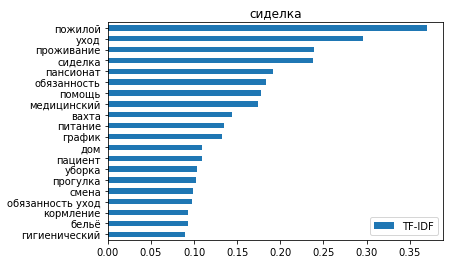

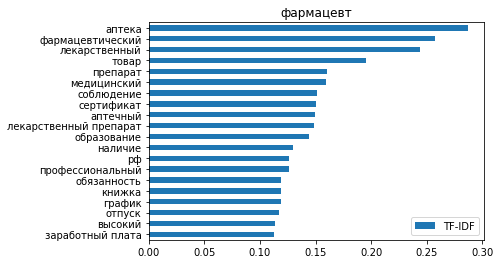

In [55]:
for job in job_list:
    tfidf_dict[job].head(20).sort_values(by='TF-IDF', ascending=True).plot(kind='barh')
    plt.title(job)
    plt.show()

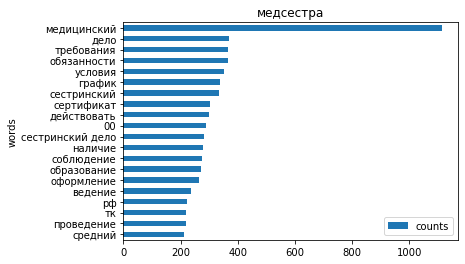

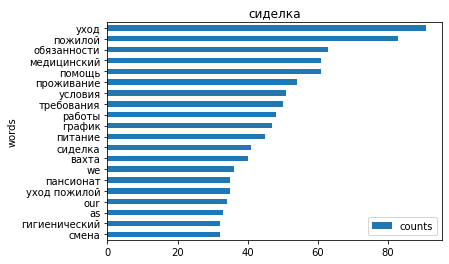

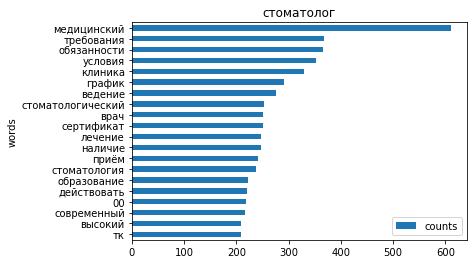

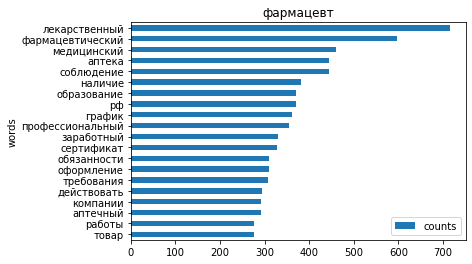

In [56]:
for job in range(len(job_list)):
    count_list[job][1].set_index('words').sort_values(by='counts', ascending=True).plot(kind='barh')
    plt.title(count_list[job][0])
    plt.show()

In [57]:
count_list

[('медсестра',
                 words  counts
  0        медицинский  1116.0
  1               дело   368.0
  2         требования   367.0
  3        обязанности   366.0
  4            условия   351.0
  5             график   338.0
  6        сестринский   334.0
  7         сертификат   304.0
  8        действовать   300.0
  9                 00   289.0
  10  сестринский дело   282.0
  11           наличие   278.0
  12        соблюдение   275.0
  13       образование   273.0
  14        оформление   266.0
  15           ведение   235.0
  16                рф   222.0
  17        проведение   218.0
  18                тк   218.0
  19           средний   213.0),
 ('сиделка',
              words  counts
  0            уход    91.0
  1         пожилой    83.0
  2     обязанности    63.0
  3     медицинский    61.0
  4          помощь    61.0
  5      проживание    54.0
  6         условия    51.0
  7      требования    50.0
  8          работы    48.0
  9          график    47.0
  10       

In [58]:
tfidf_dict[job_list[0]].head(20)

,TF-IDF
медицинский,0.293966
клиника,0.241336
пациент,0.226164
лечение,0.216681
стоматология,0.191380
обязанность,0.179698
приём,0.172586
врач,0.164052
стоматолог,0.157595
стоматологический,0.148464
